In [23]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN

In [24]:
#create a pandas dataframes from csv files
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)
users.head(2)

,user_id,name,lang,bot,subscribing_date,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used,like/statuses
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,132,5,0,5,13,0,37,0.04
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,122,3,0,6,4,0,41,0.05


In [25]:
users_clean = users.drop(columns= ['subscribing_date', 'lang', 'name', 'like/statuses', 'user_id'] , axis=1)
users_clean.head(5)

,bot,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,urls_used,mentions_used
0,1,76,132,5,0,5,13,0,37
1,0,54,122,3,0,6,4,0,41
2,1,3,4,0,0,0,0,0,0
3,1,50,1434,631,0,248,92,36,3
4,0,7085,3650,61,0,223,475,3,1913


## Correlation Analysis

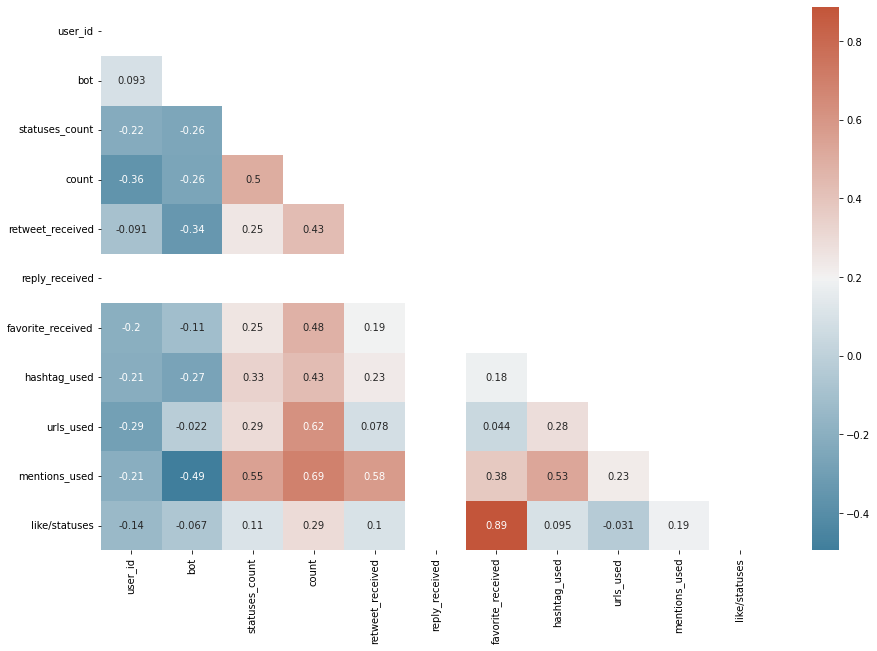

In [26]:
plt.figure(figsize=(15,10))

a = users.corr()
mask = np.triu(np.ones_like(a, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(a, annot=True, mask = mask, cmap=cmap)

plt.show()

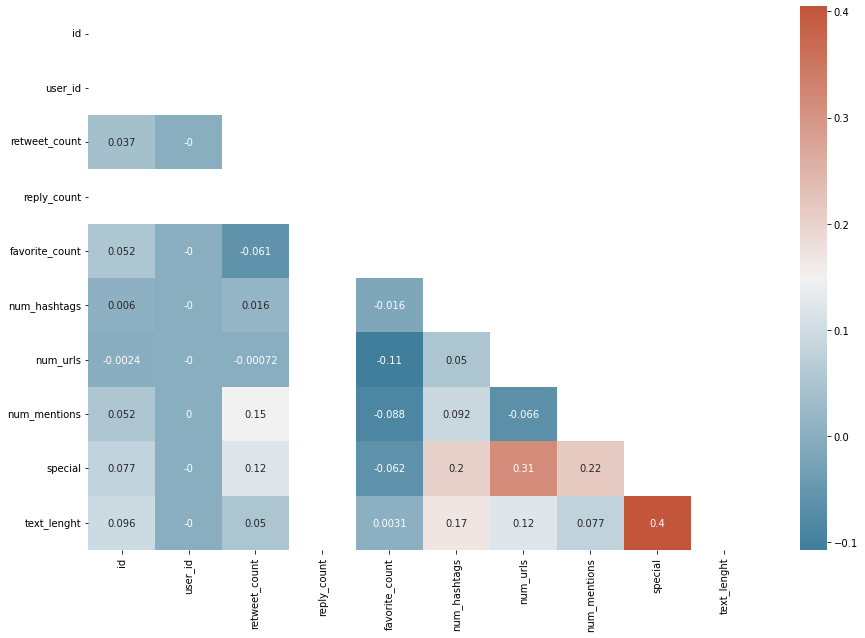

In [27]:
plt.figure(figsize=(15,10))

a = tweets.corr()
mask = np.triu(np.ones_like(a, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(a, annot=True, mask = mask, cmap=cmap)

plt.show()

# Kmeans

### Find best k with elbow method

In [28]:
scaler = StandardScaler()
X = users_clean[['retweet_received', 'favorite_received']]
X_scaler = scaler.fit_transform(X)

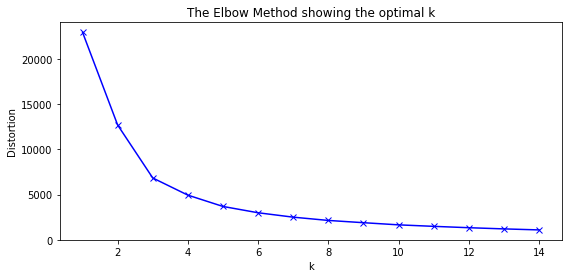

In [29]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaler)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(9,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(X_scaler)

KMeans(n_clusters=4)

In [31]:
centers = kmeanModel.cluster_centers_
centers = scaler.fit_transform(centers)

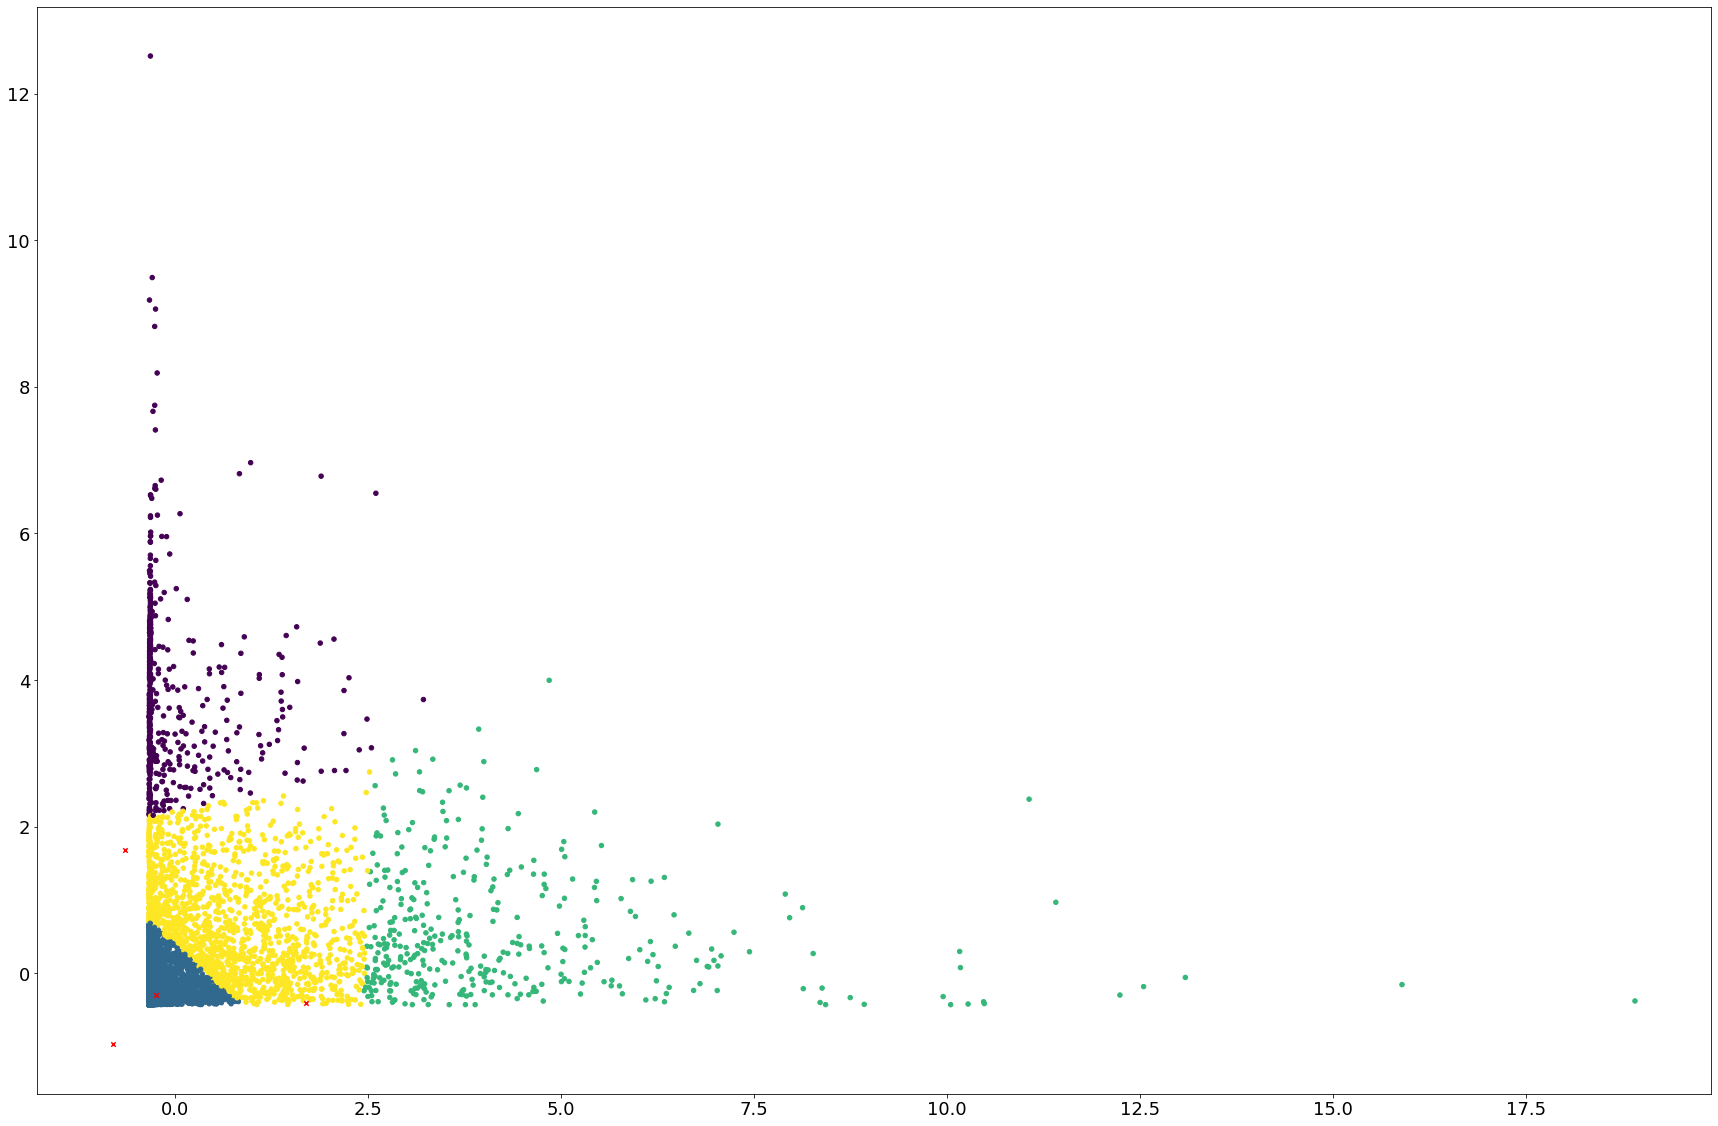

In [46]:
plt.figure(figsize = (30,20))
plt.scatter(X_scaler[:,0], X_scaler[:,1], c=kmeanModel.labels_, s=20)
plt.scatter(centers[:,0], centers[:,1],  c='red', marker='x', s=20)
plt.tick_params(labelsize=18)
plt.show()

# Hierarchical clustering

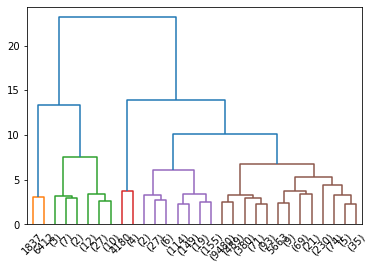

In [33]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

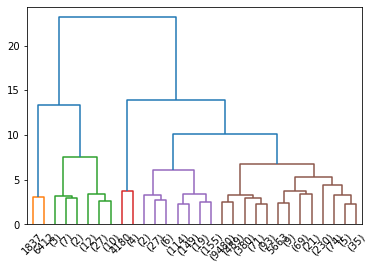

In [34]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=10, truncate_mode='lastp')

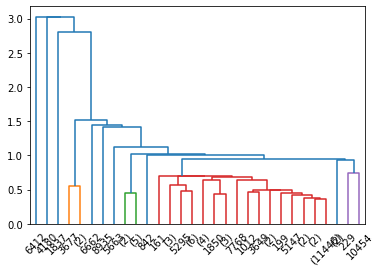

In [35]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.75, truncate_mode='lastp')

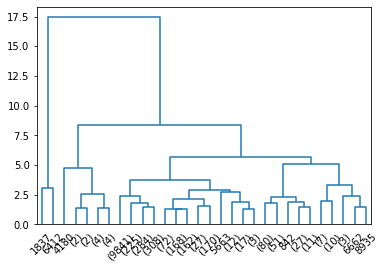

In [36]:
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

In [37]:
#with sciki-learn you have to select the number of clusters you want
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_scaler)


array([0, 0, 0, ..., 0, 0, 3])

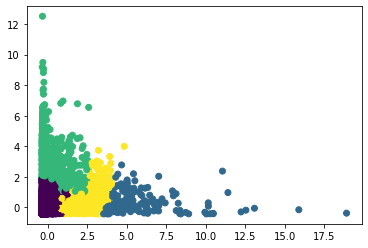

In [38]:
plt.scatter(X_scaler[:,0], X_scaler[:,1], c=cluster.labels_)

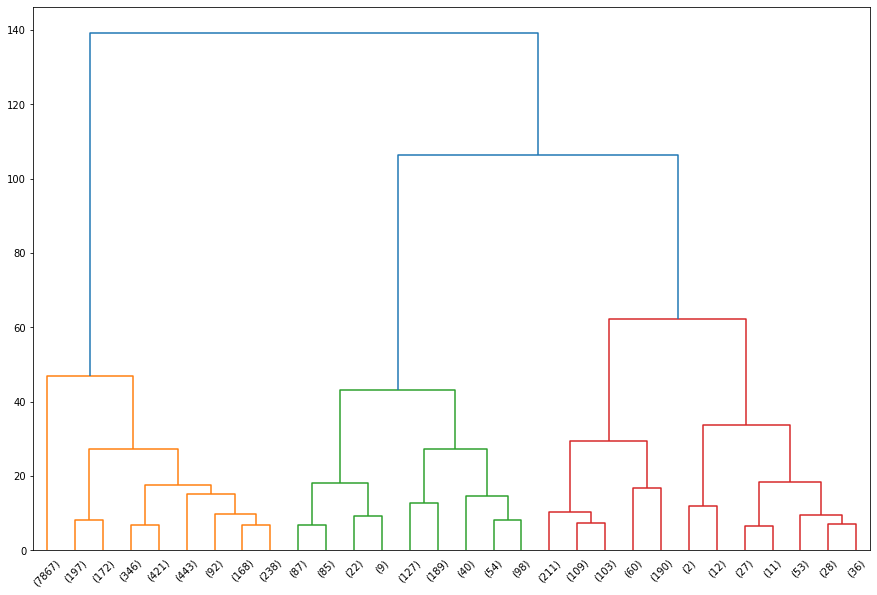

In [39]:
plt.figure(figsize=(15,10))
data_dist = pdist(X_scaler, metric='euclidean')
data_link = linkage(data_dist, method='ward')

res = dendrogram(data_link, truncate_mode='lastp')

# Density clustering

In [40]:
dbscan = DBSCAN(eps=0.15, min_samples=3)
dbscan.fit(X_scaler)

DBSCAN(eps=0.15, min_samples=3)

In [41]:
dbscan.labels_[:5]

array([0, 0, 0, 0, 0])

In [42]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
 array([  191, 11149,    11,     6,    39,     3,     4,    12,     4,
            4,     3,     5,     5,     8,     5,     7,     3,     3,
            3,     3,     7,     3,     5,     3,     3,     5,     3]))

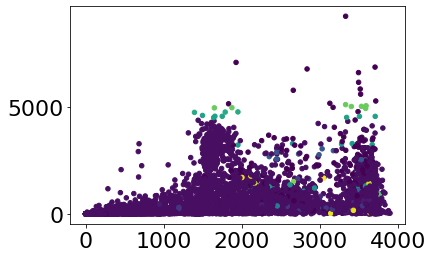

In [43]:
plt.scatter(users_clean['count'], users_clean['favorite_received'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [44]:
print('Silhouette %s' % silhouette_score(X_scaler, dbscan.labels_))

Silhouette 0.6271910669671235
